## Get theta power time-locked to trial onset: SLCH002

In [1]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns
import scipy
import joblib

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra



In [2]:
## Prep paths ##

subject = 'SLCH002'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [3]:
## Load Neural Data

# load
pres_locked_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_ieeg.fif")

# get good epochs (for behavioral data only)
good_epochs = [i for i,x in enumerate(pres_locked_epochs.get_annotations_per_epoch()) if not x]
bad_epochs = [i for i,x in enumerate(pres_locked_epochs.get_annotations_per_epoch()) if  x]

# onlt good epochs
pres_locked_epochs = pres_locked_epochs[good_epochs]


Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_clean_pres-locked_ieeg.fif ...


/tmp/ipykernel_133838/923474851.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_clean_pres-locked_ieeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  pres_locked_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_ieeg.fif")


    Found the data of interest:
        t =   -4000.00 ...   12000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_clean_pres-locked_ieeg-1.fif ...
    Found the data of interest:
        t =   -4000.00 ...   12000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_clean_pres-locked_ieeg-2.fif ...
    Found the data of interest:
        t =   -4000.00 ...   12000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
0 bad epochs dropped
0 bad epochs dropped
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated


In [4]:
len(good_epochs)

163

In [52]:
## Dictionary of electrode locations ##

ROIs = {
    'hc'     :['K2', 'K3', 'K4', 'K5', 'K6', 'J4', 'J5', 'J6', 'K7'],
    'ec'     :['h1', 'h2', 'h3', 'h4', 'L1', 'L2', 'L3', 'L4'],
    'ofc'    :['A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'B5', 'B6', 'B7', 'B8', 'B9'],
    'amyg'   :['i1', 'i2', 'i3', 'i4', 'i5'],
    'insula' :['C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'E2', 'E3', 'E4', 'F1', 'F2', 'F3'],
    'mtg'    :['i12', 'i13', 'i14', 'J10', 'J11', 'J12', 'J13', 'K14', 'K15'],
    'cing'   :['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4']
}

hc_list = []
hc_indices = []
hc_names = []
ec_list = []
ec_indices = []
ec_names = []
ofc_list = []
ofc_indices = []
ofc_names = []
amyg_list = []
amyg_names = []               
insula_list = []
insula_names = []            
cing_list = []
cing_names = []   
mtg_list = []
mtg_indices = []
mtg_names = []
pairs_long_name = [ch.split('-') for ch in pres_locked_epochs.info['ch_names']]
bidx = len(pres_locked_epochs.info['bads']) +1
pairs_name = pairs_long_name[bidx:len(pairs_long_name)]

for ix in range(0, len(pairs_name)):
    if pairs_name[ix][0] in ROIs['hc'] or pairs_name[ix][1] in ROIs['hc']:
        hc_list.append(pres_locked_epochs.info['ch_names'][ix + bidx])
        hc_names.append(pairs_name[ix])
        hc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ec'] or pairs_name[ix][1] in ROIs['ec']:
        ec_list.append(pres_locked_epochs.info['ch_names'][ix + bidx])
        ec_names.append(pairs_name[ix])
        ec_indices.append(ix)        
    if pairs_name[ix][0] in ROIs['ofc'] or pairs_name[ix][1] in ROIs['ofc']:
        ofc_list.append(pres_locked_epochs.info['ch_names'][ix + bidx])
        ofc_names.append(pairs_name[ix])
        ofc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['amyg'] or pairs_name[ix][1] in ROIs['amyg']:
        amyg_list.append(pres_locked_epochs.info['ch_names'][ix + bidx])       
        amyg_names.append(pairs_name[ix])
    if pairs_name[ix][0] in ROIs['insula'] or pairs_name[ix][1] in ROIs['insula']:
        insula_list.append(pres_locked_epochs.info['ch_names'][ix + bidx])       
        insula_names.append(pairs_name[ix])
    if pairs_name[ix][0] in ROIs['cing'] or pairs_name[ix][1] in ROIs['cing']:
        cing_list.append(pres_locked_epochs.info['ch_names'][ix + bidx])       
        cing_names.append(pairs_name[ix])
    if pairs_name[ix][0] in ROIs['mtg'] or pairs_name[ix][1] in ROIs['mtg']:
        mtg_list.append(pres_locked_epochs.info['ch_names'][ix + bidx])       
        mtg_names.append(pairs_name[ix])        
        
print(ec_list)

['h1-h2', 'h2-h3', 'h3-h4', 'h4-h5', 'L1-L2', 'L2-L3', 'L3-L4', 'L4-L5']


In [53]:
mtg_list

['i11-i12',
 'i12-i13',
 'i13-i14',
 'J9-J10',
 'J10-J11',
 'J11-J12',
 'J12-J13',
 'J13-J14',
 'K13-K14',
 'K14-K15',
 'K15-K16']

In [6]:
def MM_compute_TFR(epochs, freqs, n_cycles, baseline, zscore=True, time_bandwidth=None):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_morlet(epochs,freqs,n_cycles,return_itc=False,
                                            average=False,  n_jobs = 8)
    print('log transforming')
    TFR.data = np.log(TFR.data)
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,:,bix].mean(axis=(3),keepdims=True)
        bstd = TFR.data[:,:,:,bix].std(axis=(3),keepdims=True)
        TFR.data = (TFR.data - bmean) / bstd
    return TFR



In [7]:
# Set frequencies

freqs = np.logspace(start = np.log10(1), stop = np.log10(150), num = 80, base = 10, endpoint = True)
n_cycles = np.logspace(np.log10(2), np.log10(30), base = 10, num = 80)

# formulas to check bandwidth and time bin
band_width = (freqs / n_cycles) * 2
time_bin = n_cycles / freqs / np.pi
print(freqs)
print(n_cycles)
print(time_bin)
print(band_width)


[  1.           1.06548039   1.13524845   1.20958496   1.28878905
   1.37317945   1.46309577   1.55889984   1.6609772    1.76973863
   1.8856218    2.00909304   2.14064922   2.28081976   2.43016872
   2.5892971    2.75884527   2.93949552   3.13197482   3.33705774
   3.55556956   3.78838962   4.03645484   4.30076345   4.5823791
   4.88243505   5.20213877   5.54277682   5.90571998   6.2924288
   6.70445946   7.14347005   7.61122722   8.10961331   8.64063391
   9.20642595   9.80926626  10.45158079  11.13595433  11.8651409
  12.6420749   13.46988283  14.35189595  15.29166362  16.29296764
  17.35983743  18.49656627  19.70772855  20.99819821  22.37316831
  23.83817199  25.39910467  27.06224782  28.83429423  30.72237491
  32.73408785  34.87752853  37.16132253  39.59466023  42.18733383
  44.94977669  47.89310538  51.02916436  54.37057369  57.93077979
  61.72410955  65.76582801  70.07219975  74.66055437  79.54935622
  84.75827869  90.30828341  96.22170458 102.52233885 109.23554107
 116.38832636

### Hippocampus

In [8]:
hc_list

['J4-J5',
 'J5-J6',
 'J6-J7',
 'K1-K2',
 'K2-K3',
 'K3-K4',
 'K4-K5',
 'K5-K6',
 'K6-K7',
 'K7-K8']

In [9]:
hc_pres_epochs = pres_locked_epochs.copy().pick_channels(hc_list)


In [10]:
hc_pres_epochs= hc_pres_epochs.resample(1000)


In [11]:
## Compute TFR

hc_pres_TFR = []
hc_pres_TFR = MM_compute_TFR(hc_pres_epochs,freqs,n_cycles,baseline = (-1,9), zscore=True)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  3.0min finished


Not setting metadata
log transforming
z-scoring to baseline


In [12]:
hc_pres_TFR.crop(tmin = 0, tmax = 9)


<EpochsTFR | time : [0.000000, 9.000000], freq : [1.000000, 150.000000], epochs : 163, channels : 10, ~8.74 GB>

/tmp/ipykernel_133838/1059565407.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


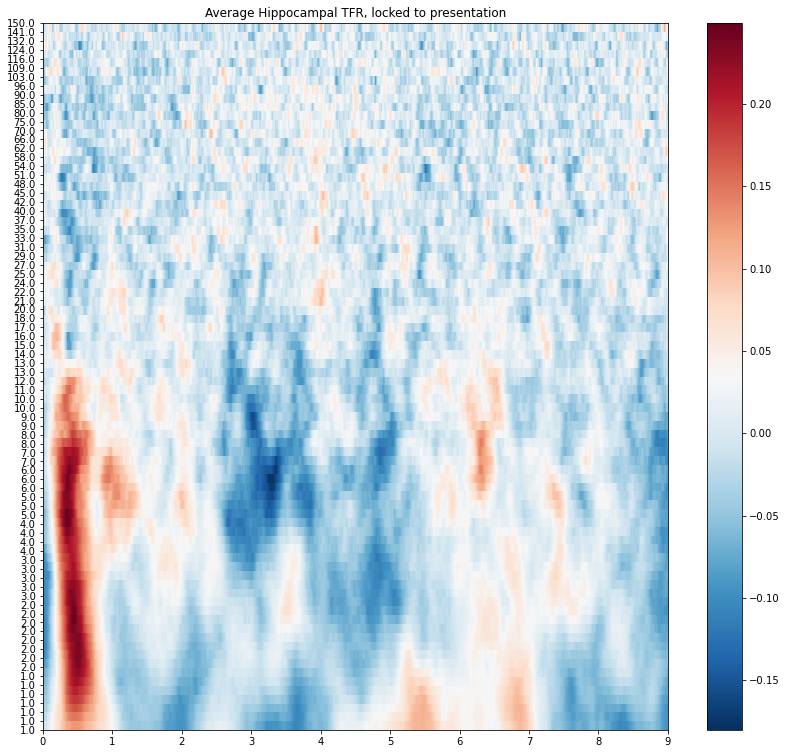

In [15]:
plt.rcParams['figure.figsize'] = [14, 13]


fig, ax = plt.subplots()
i = ax.imshow(hc_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[0, 9, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(hc_pres_TFR.freqs),np.max(hc_pres_TFR.freqs),len(hc_pres_TFR.freqs)))
ax.set_yticklabels(np.round(hc_pres_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Hippocampal TFR, locked to presentation")
fig.show()


/tmp/ipykernel_133838/3358442580.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


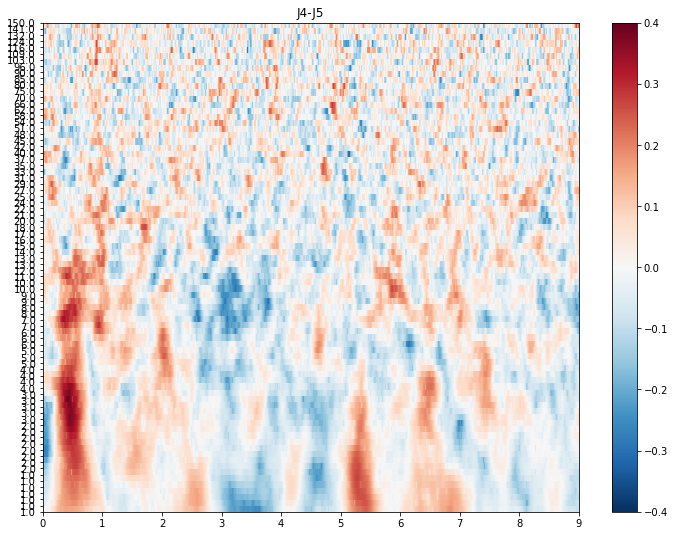

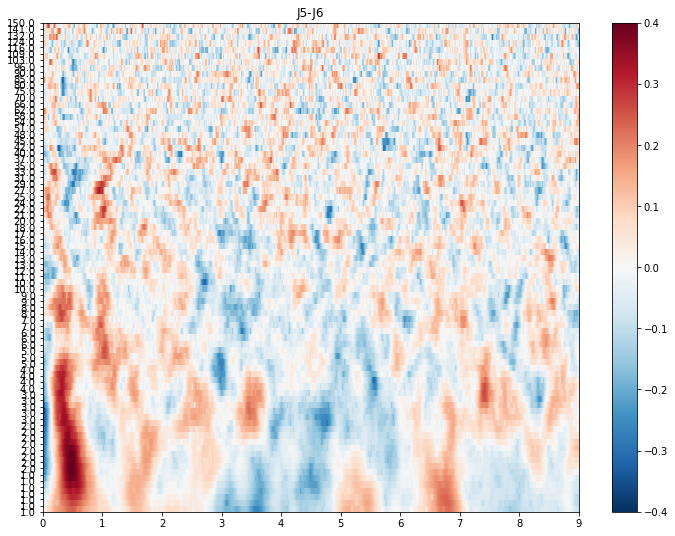

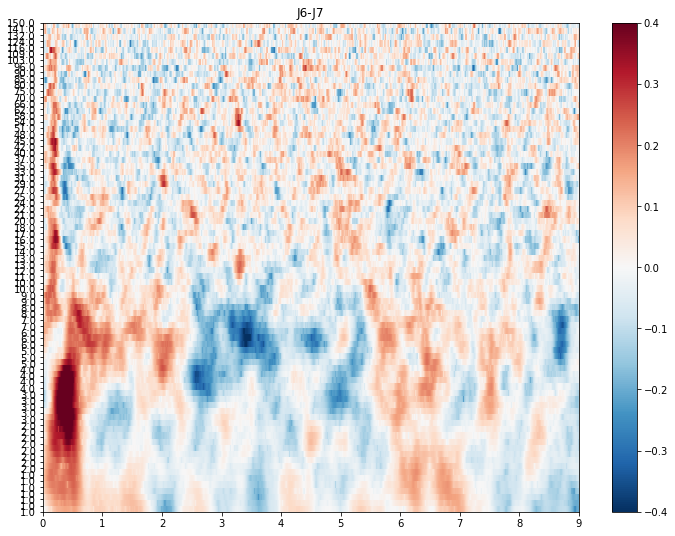

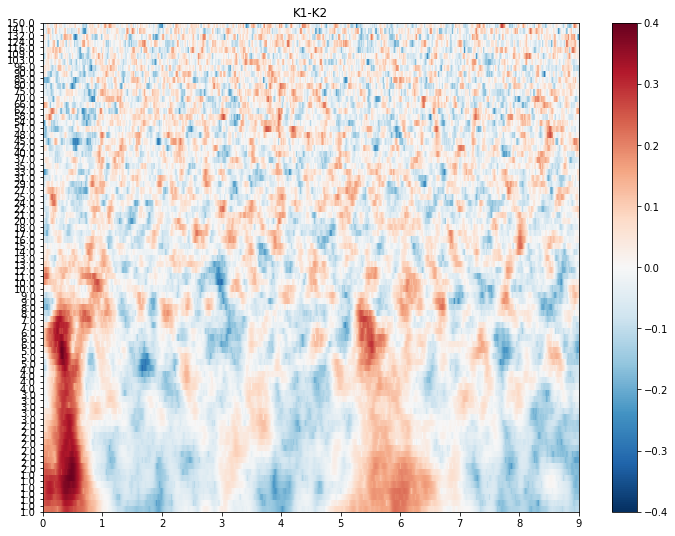

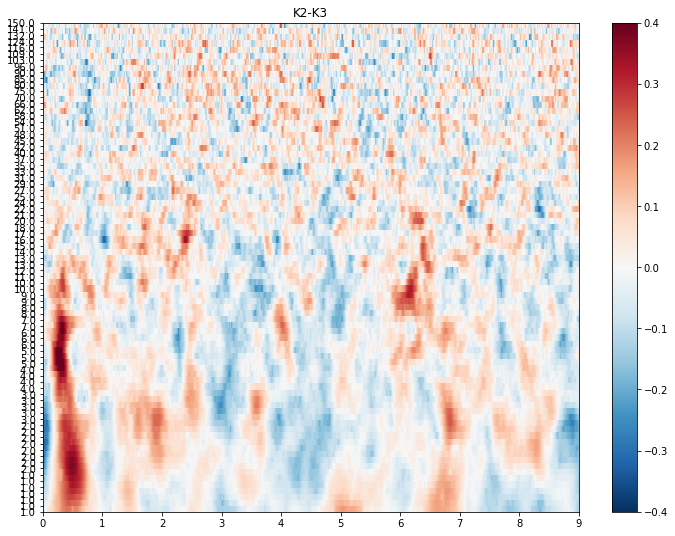

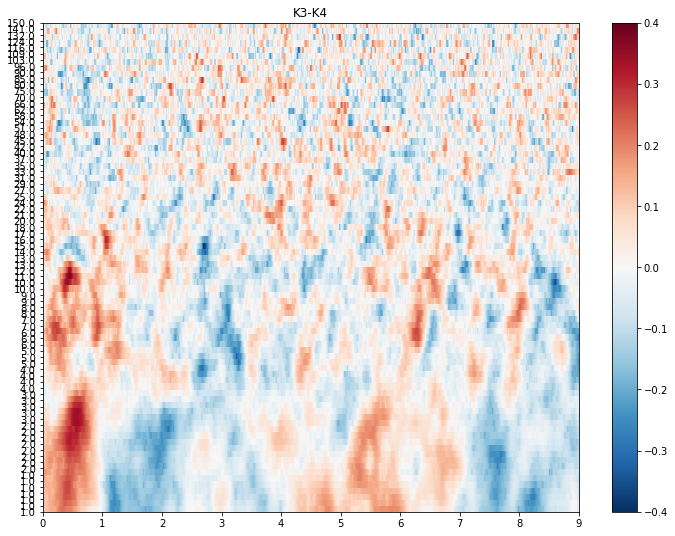

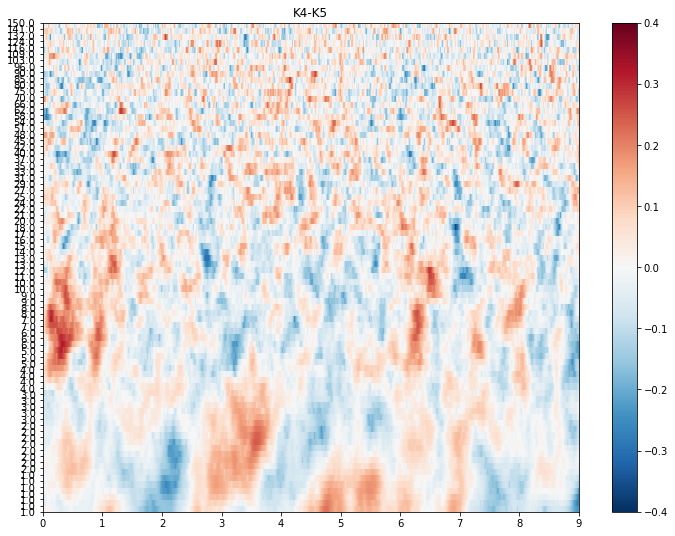

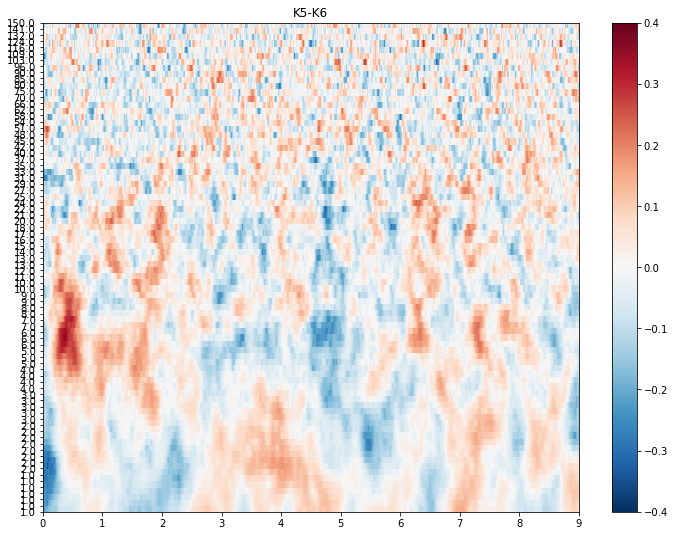

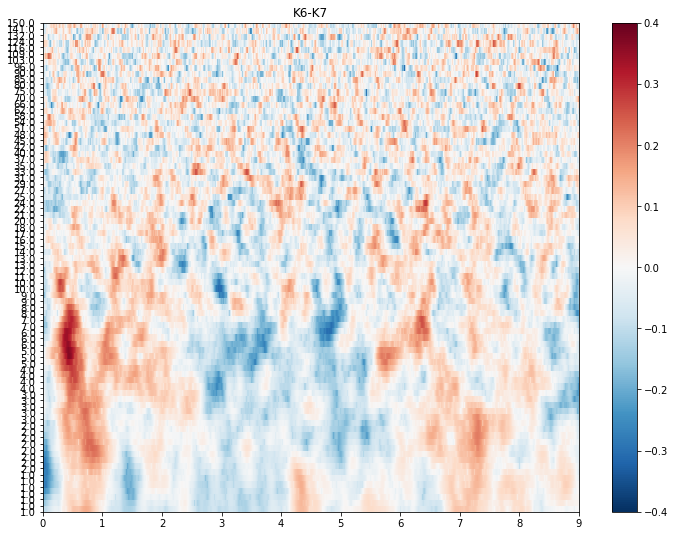

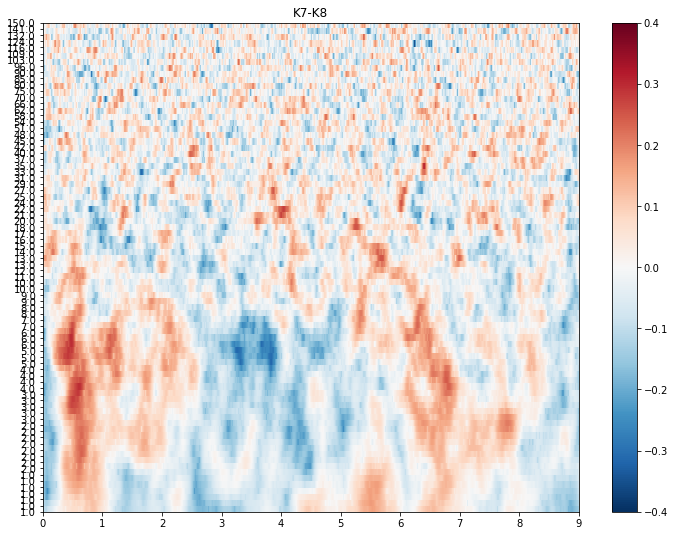

In [16]:
plt.rcParams['figure.figsize'] = [12, 9]

chix = 0
for ch in hc_pres_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(hc_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[0, 9, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(hc_pres_TFR.freqs),np.max(hc_pres_TFR.freqs),len(hc_pres_TFR.freqs)))
    ax.set_yticklabels(np.round(hc_pres_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}")
    fig.show()

    
    chix = chix + 1

In [17]:
# loop over channels and save csvs
fidx = np.where((freqs > 3) & (freqs < 8))[0]

for chix in range(len(hc_pres_TFR.ch_names)):

    trial_theta_power = hc_pres_TFR.data[:, chix, fidx, :].mean(axis = 1)
    channel_df = pd.DataFrame(trial_theta_power[:, ::50])
    channel_df['trial'] = good_epochs
        
    channel_df.to_csv(f"{preproc_data_dir}/theta_csvs/{hc_pres_TFR.ch_names[chix]}_hc_trial_theta.csv")

In [18]:
channel_df

0         1         2         3         4         5         6  \
0   -0.477559 -0.653131 -0.319245  0.338559  0.836432  1.129683  1.251157   
1    0.408813  0.406947  0.335546  0.371898  0.312401  0.131165  0.051297   
2    1.347280  1.243098  0.988114  0.577017 -0.005132 -0.104352 -0.153631   
3    0.638132  0.220569 -0.179436 -0.099046 -0.094512 -0.207409  0.139975   
4   -1.332704 -1.466162 -1.330476 -0.680704 -0.201599  0.138157  0.349682   
..        ...       ...       ...       ...       ...       ...       ...   
158 -0.542432 -0.460085 -0.538851 -0.732272 -0.657584 -0.142792  0.186756   
159 -0.584290 -0.413600 -0.367676 -0.130284  0.286491  0.620219  0.898769   
160 -1.270375 -0.938997 -0.672448 -0.565113 -0.624362 -0.816001 -0.658437   
161 -0.718905 -0.362191 -0.088861  0.527218  1.044398  1.402539  1.611460   
162 -0.083385 -0.177762 -0.290997 -0.390080 -0.110716  0.017922 -0.007190   

            7         8         9  ...       172       173       174  \
0    1.243374  1.189042  1.062686  ... -0.474884 -0.281503 -0.213978   
1   -0.091220  0.027635  0.296000  ...  0.583668  1.166847  1.565998   
2   -0.101059 -0.147609 -0.383463  ... -0.849205 -0.775827 -0.380634   
3    0.333791  0.361113  0.237646  ...  0.252685  0.374431  0.333090   
4    0.443540  0.428369  0.276600  ...  0.059779  0.014890 -0.154953   
..        ...       ...       ...  ...       ...       ...       ...   
158  0.372259  0.421041  0.342521  ... -1.266202 -1.128433 -0.994706   
159  1.228686  1.535654  1.731854  ... -0.189556 -0.056225 -0.045877   
160 -0.186874  0.229227  0.483414  ... -0.579549 -0.414257 -0.438323   
161  1.681420  1.620997  1.435059  ...  0.275183  0.325396  0.259078   
162 -0.178618 -0.487541 -0.926308  ...  0.264054  0.021044 -0.369585   

          175       176       177       178       179       180  trial  
0    0.029697  0.537175  0.902223  1.110214  1.155554  1.033060      0  
1    1.799314  1.873838  1.792893  1.560447  1.186336  0.989672      1  
2    0.100451  0.408296  0.552587  0.549398  0.414681  0.159406      2  
3    0.138931 -0.179211 -0.497409 -0.309203 -0.202970 -0.228776      3  
4   -0.479969 -0.610838 -0.535416 -0.575114 -0.773217 -1.171794      4  
..        ...       ...       ...       ...       ...       ...    ...  
158 -1.023311 -1.197315 -1.503430 -1.940699 -2.192941 -1.891792    232  
159 -0.159756 -0.276211  0.023105  0.244406  0.401118  0.481930    233  
160 -0.666596 -0.918061 -0.743289 -0.339476 -0.122401 -0.077763    234  
161  0.072492 -0.063316  0.115429  0.131297 -0.027454 -0.370810    235  
162 -0.677488 -0.875011 -0.785139 -0.512218 -0.000288  0.370851    236  

[163 rows x 182 columns]

In [ ]:
fig, ax = plt.subplots()



i = ax.plot(hc_pres_TFR.times, average_trial_theta_power, color = 'red')
# i = ax.plot(hc_pres_TFR.times[1::50], trial_theta_power_dec.mean(axis = 1).mean(axis = 0), color = 'blue')
i = ax.plot(hc_pres_TFR.times[::50], average_trial_theta_power[::50], color = 'orange')
fig.show()

## OFC

In [19]:
hc_pres_epochs = pres_locked_epochs.copy().pick_channels(ofc_list)


In [20]:
hc_pres_epochs= hc_pres_epochs.resample(1000)


In [21]:
## Compute TFR

hc_pres_TFR = []
hc_pres_TFR = MM_compute_TFR(hc_pres_epochs,freqs,n_cycles,baseline = (-1,9), zscore=True)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   9 out of  13 | elapsed:  3.1min remaining:  1.4min
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:  3.3min finished


Not setting metadata
log transforming
z-scoring to baseline


In [22]:
hc_pres_TFR.crop(tmin = 0, tmax = 9)


<EpochsTFR | time : [0.000000, 9.000000], freq : [1.000000, 150.000000], epochs : 163, channels : 13, ~11.37 GB>

/tmp/ipykernel_133838/1771540224.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


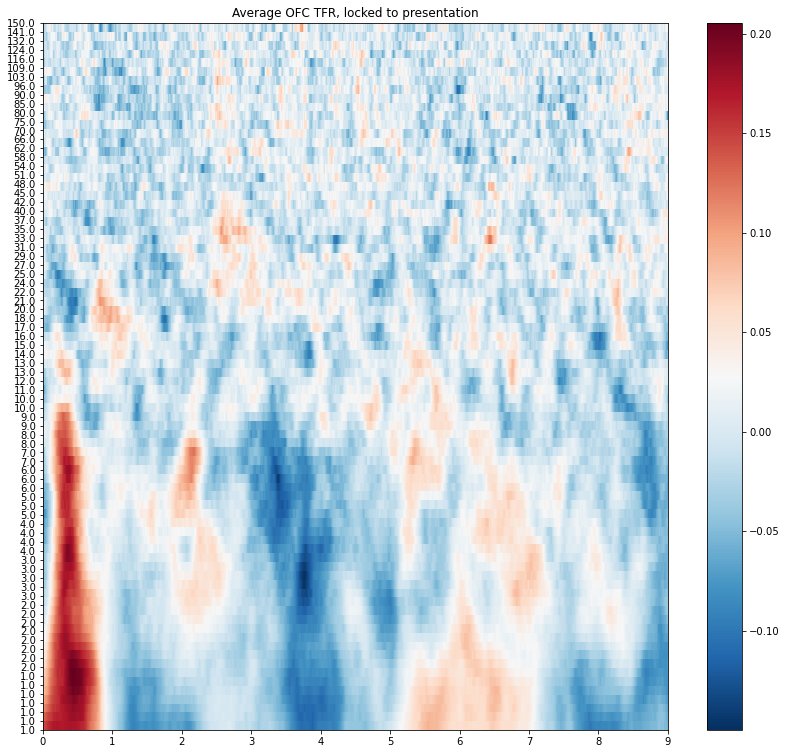

In [23]:
plt.rcParams['figure.figsize'] = [14, 13]


fig, ax = plt.subplots()
i = ax.imshow(hc_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[0, 9, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(hc_pres_TFR.freqs),np.max(hc_pres_TFR.freqs),len(hc_pres_TFR.freqs)))
ax.set_yticklabels(np.round(hc_pres_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average OFC TFR, locked to presentation")
fig.show()


/tmp/ipykernel_133838/3358442580.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


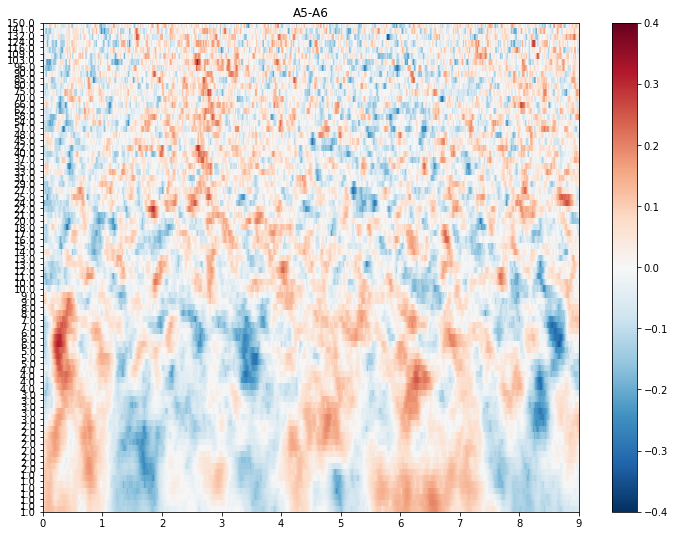

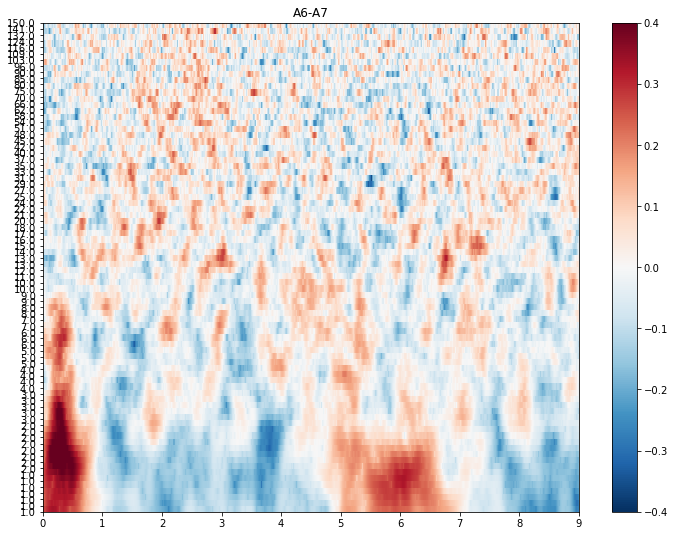

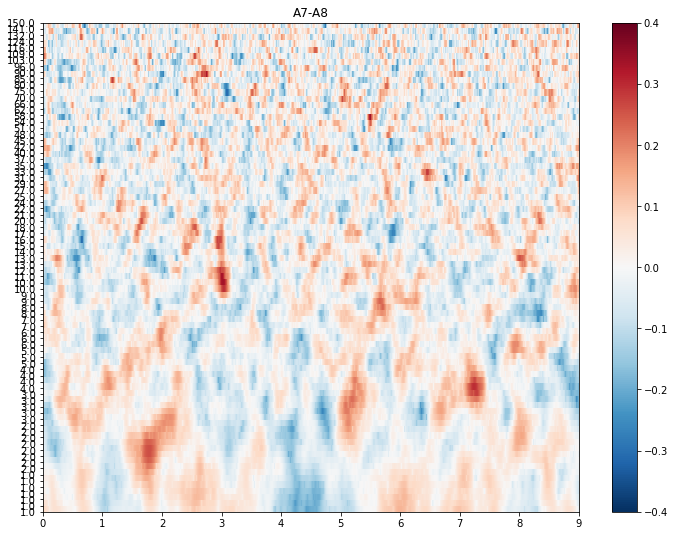

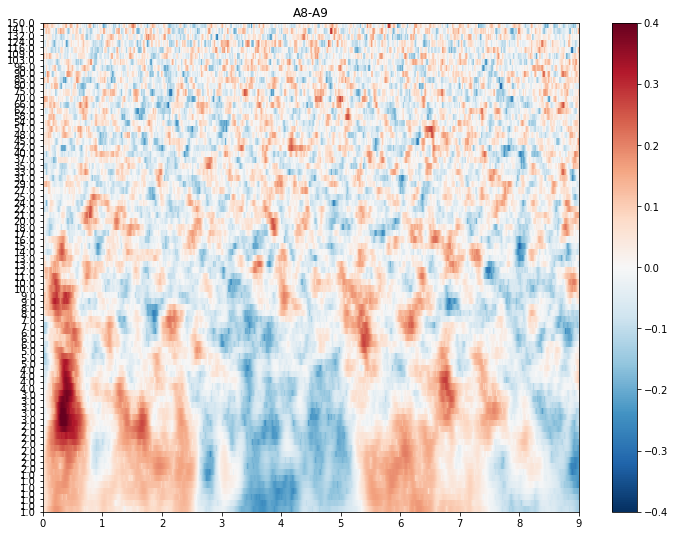

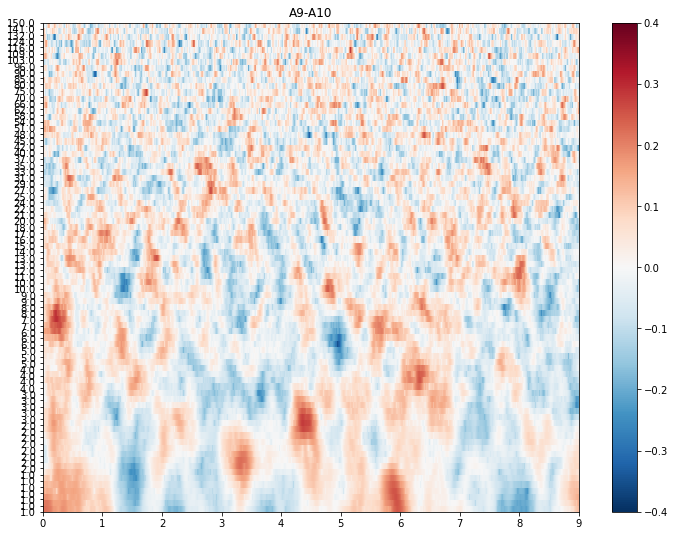

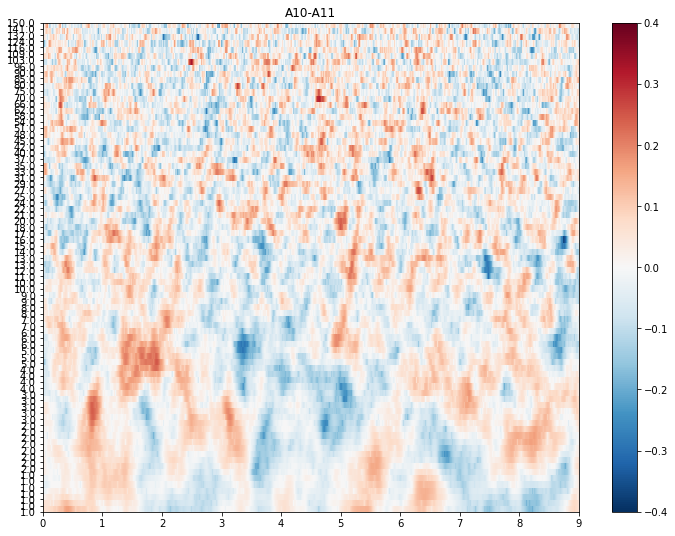

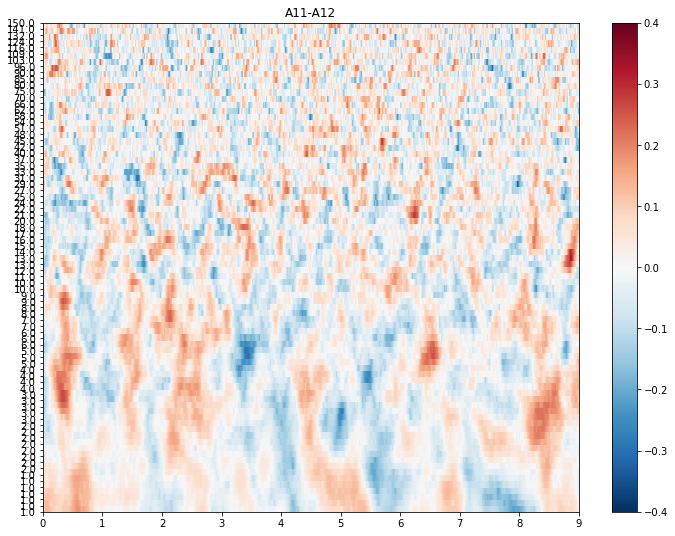

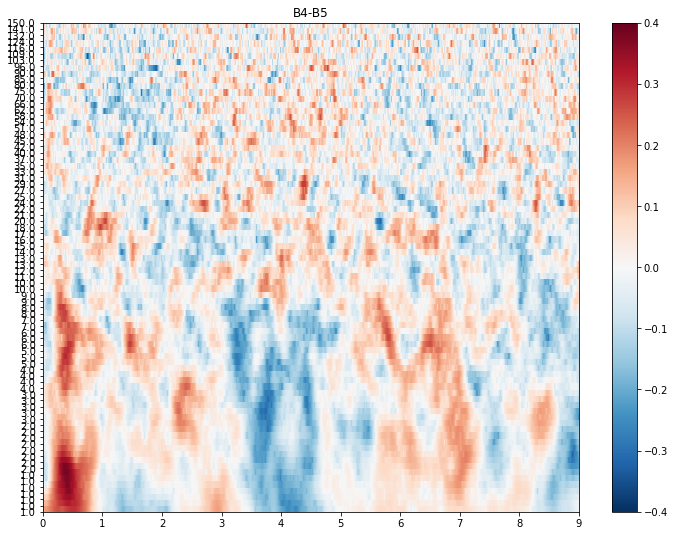

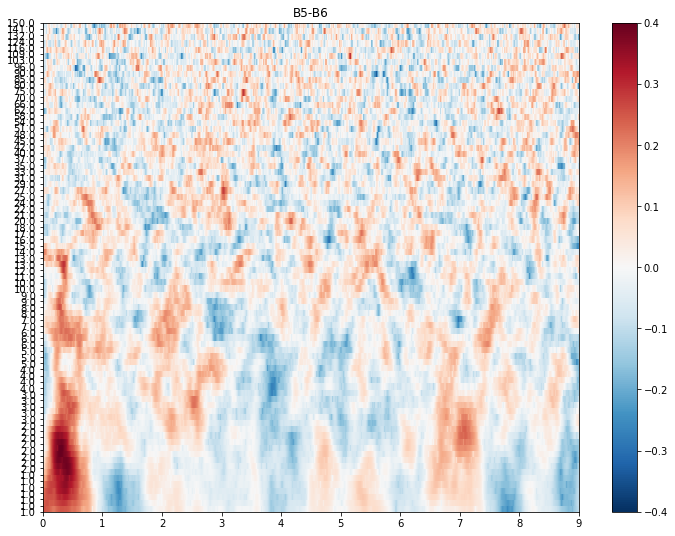

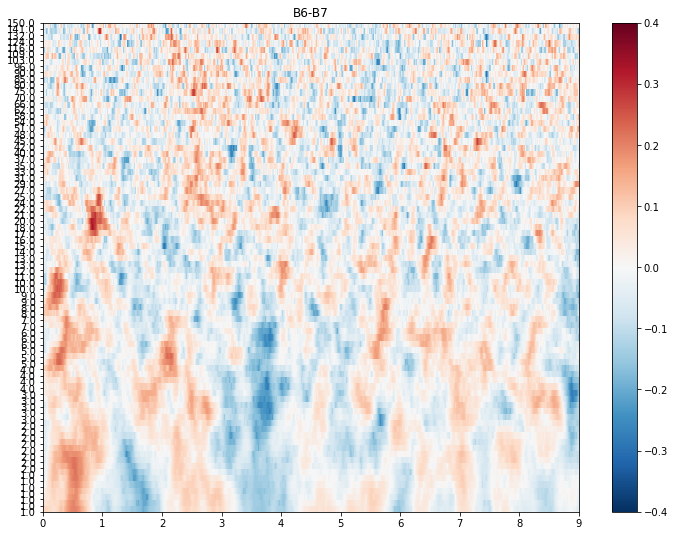

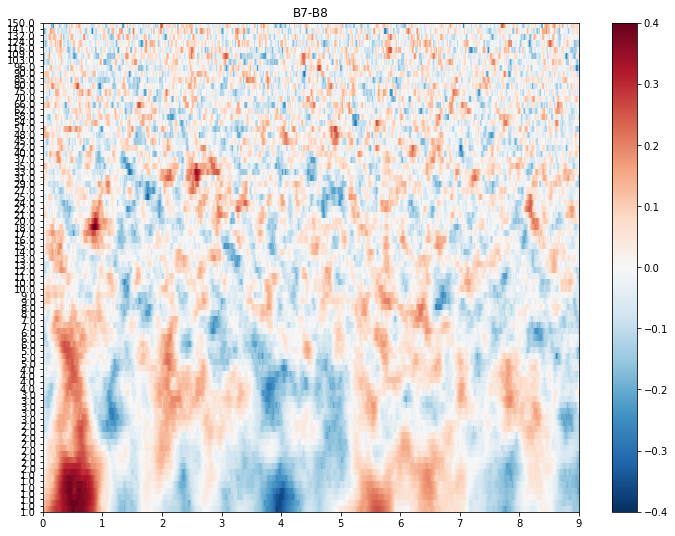

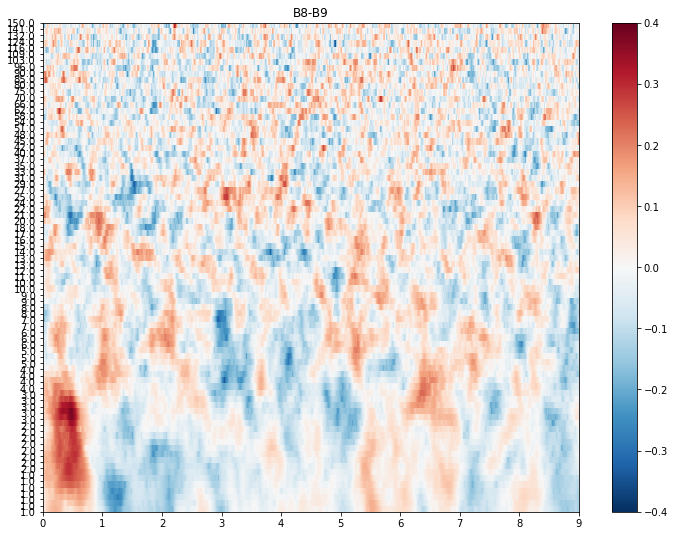

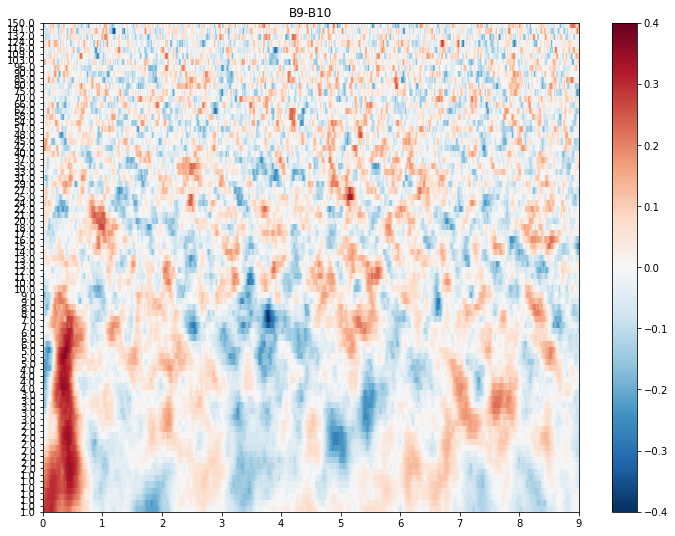

In [24]:
plt.rcParams['figure.figsize'] = [12, 9]

chix = 0
for ch in hc_pres_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(hc_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[0, 9, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(hc_pres_TFR.freqs),np.max(hc_pres_TFR.freqs),len(hc_pres_TFR.freqs)))
    ax.set_yticklabels(np.round(hc_pres_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}")
    fig.show()

    
    chix = chix + 1

In [25]:
# loop over channels and save csvs
fidx = np.where((freqs > 3) & (freqs < 8))[0]

for chix in range(len(hc_pres_TFR.ch_names)):

    trial_theta_power = hc_pres_TFR.data[:, chix, fidx, :].mean(axis = 1)
    channel_df = pd.DataFrame(trial_theta_power[:, ::50])
    channel_df['trial'] = good_epochs
        
    channel_df.to_csv(f"{preproc_data_dir}/theta_csvs/{hc_pres_TFR.ch_names[chix]}_ofc_trial_theta.csv")

## Cingulate

In [26]:
hc_pres_epochs = pres_locked_epochs.copy().pick_channels(cing_list)


In [27]:
hc_pres_epochs= hc_pres_epochs.resample(1000)


In [28]:
## Compute TFR

hc_pres_TFR = []
hc_pres_TFR = MM_compute_TFR(hc_pres_epochs,freqs,n_cycles,baseline = (-1,9), zscore=True)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.1min remaining:  3.4min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.1min remaining:  1.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.3min finished


Not setting metadata
log transforming
z-scoring to baseline


In [29]:
hc_pres_TFR.crop(tmin = 0, tmax = 9)


<EpochsTFR | time : [0.000000, 9.000000], freq : [1.000000, 150.000000], epochs : 163, channels : 8, ~7.00 GB>

/tmp/ipykernel_133838/2969052853.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


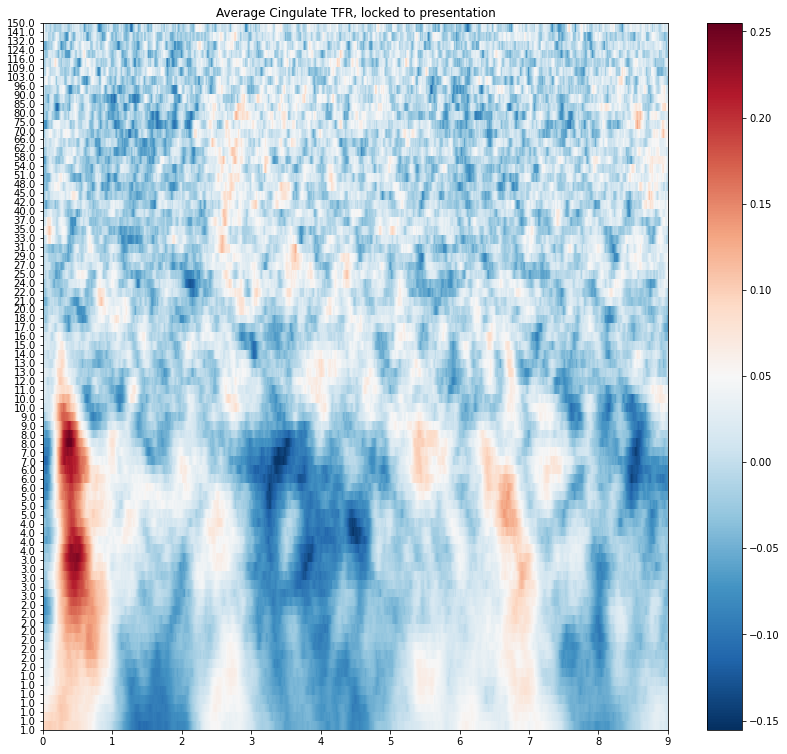

In [30]:
plt.rcParams['figure.figsize'] = [14, 13]


fig, ax = plt.subplots()
i = ax.imshow(hc_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[0, 9, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(hc_pres_TFR.freqs),np.max(hc_pres_TFR.freqs),len(hc_pres_TFR.freqs)))
ax.set_yticklabels(np.round(hc_pres_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Cingulate TFR, locked to presentation")
fig.show()


/tmp/ipykernel_133838/3358442580.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


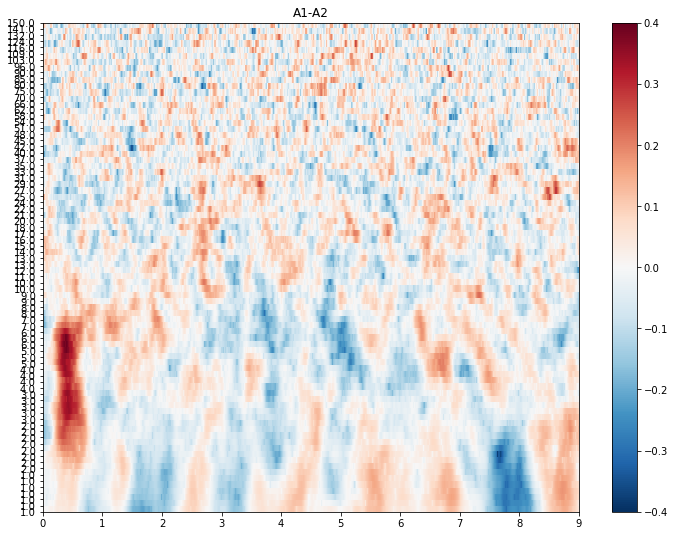

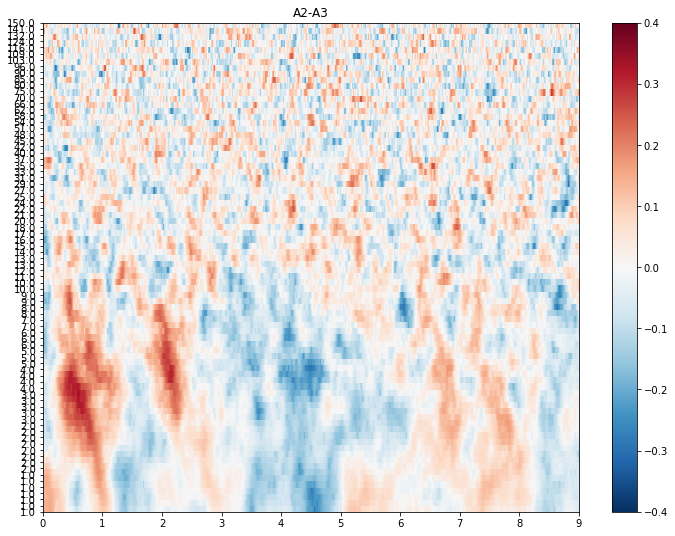

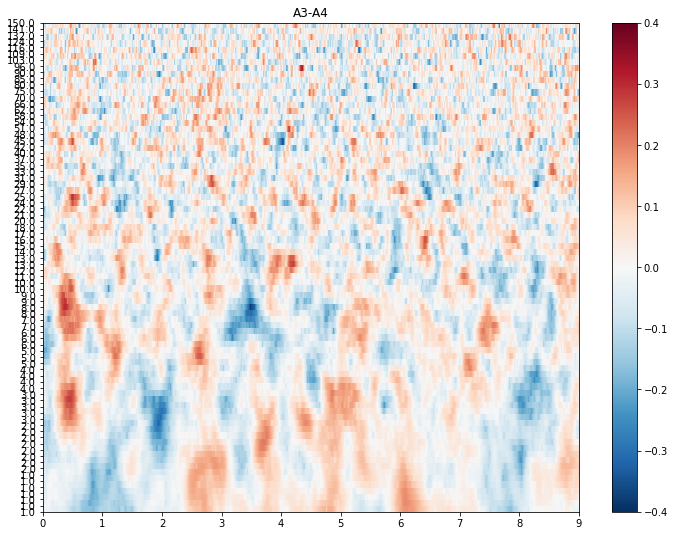

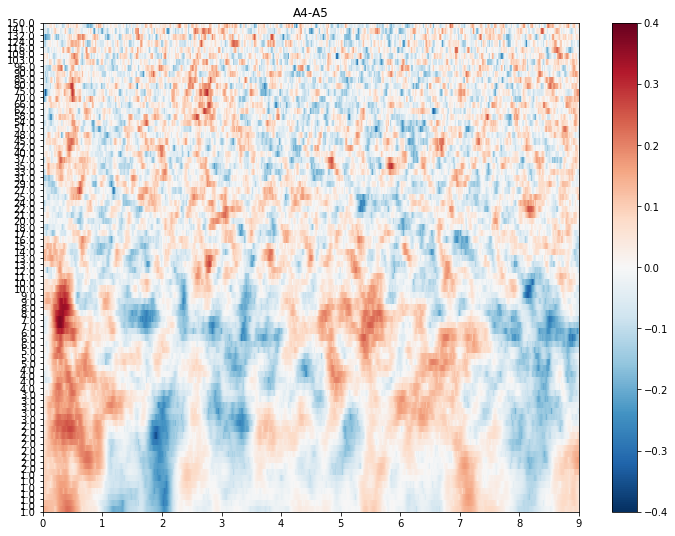

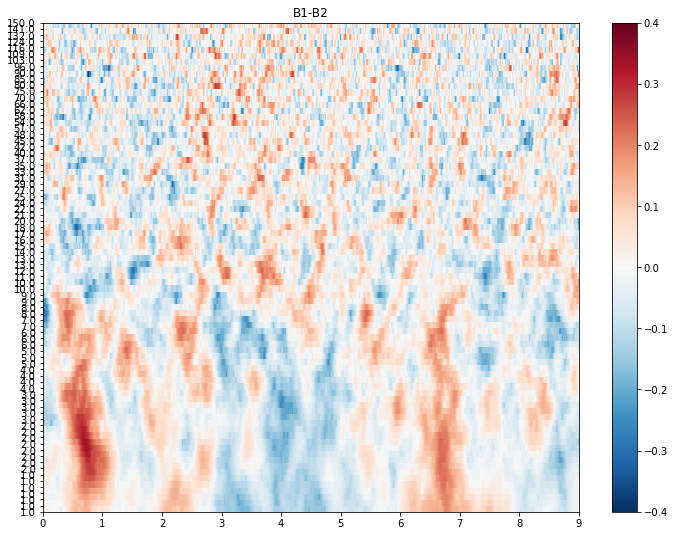

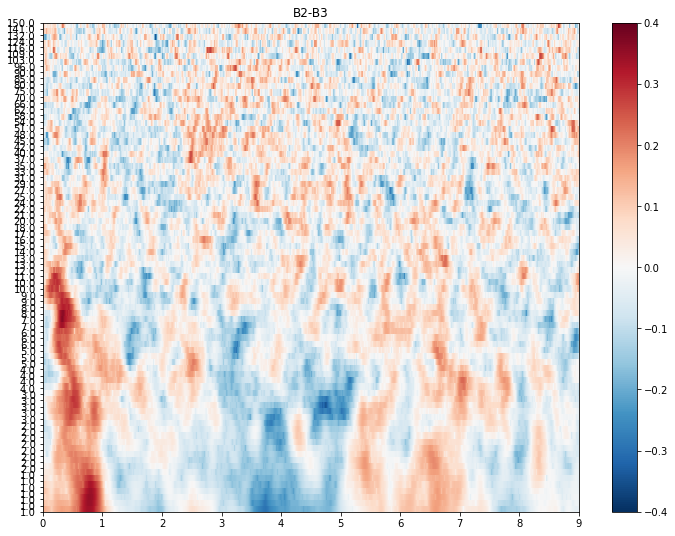

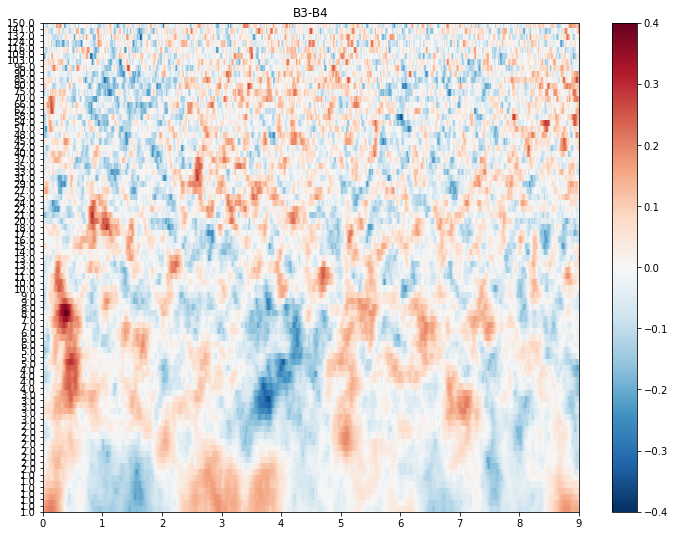

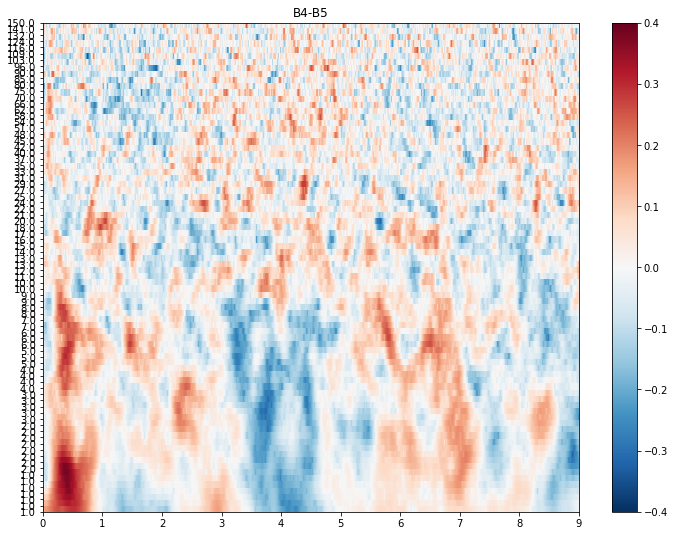

In [31]:
plt.rcParams['figure.figsize'] = [12, 9]

chix = 0
for ch in hc_pres_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(hc_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[0, 9, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(hc_pres_TFR.freqs),np.max(hc_pres_TFR.freqs),len(hc_pres_TFR.freqs)))
    ax.set_yticklabels(np.round(hc_pres_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}")
    fig.show()

    
    chix = chix + 1

In [32]:
# loop over channels and save csvs
fidx = np.where((freqs > 3) & (freqs < 8))[0]

for chix in range(len(hc_pres_TFR.ch_names)):

    trial_theta_power = hc_pres_TFR.data[:, chix, fidx, :].mean(axis = 1)
    channel_df = pd.DataFrame(trial_theta_power[:, ::50])
    channel_df['trial'] = good_epochs
        
    channel_df.to_csv(f"{preproc_data_dir}/theta_csvs/{hc_pres_TFR.ch_names[chix]}_cing_trial_theta.csv")

## Entorhinal Cortex

In [33]:
hc_pres_epochs = pres_locked_epochs.copy().pick_channels(ec_list)


In [34]:
hc_pres_epochs= hc_pres_epochs.resample(1000)


In [35]:
## Compute TFR

hc_pres_TFR = []
hc_pres_TFR = MM_compute_TFR(hc_pres_epochs,freqs,n_cycles,baseline = (-1,9), zscore=True)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.2min remaining:  3.6min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  2.2min remaining:  1.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.4min finished


Not setting metadata
log transforming
z-scoring to baseline


In [36]:
hc_pres_TFR.crop(tmin = 0, tmax = 9)


<EpochsTFR | time : [0.000000, 9.000000], freq : [1.000000, 150.000000], epochs : 163, channels : 8, ~7.00 GB>

/tmp/ipykernel_133838/4216833566.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


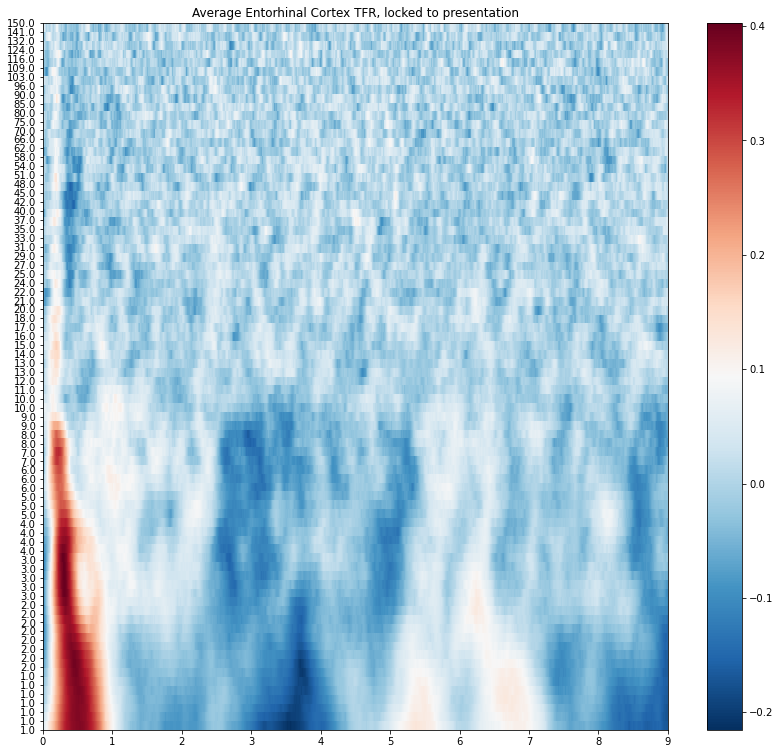

In [37]:
plt.rcParams['figure.figsize'] = [14, 13]


fig, ax = plt.subplots()
i = ax.imshow(hc_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[0, 9, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(hc_pres_TFR.freqs),np.max(hc_pres_TFR.freqs),len(hc_pres_TFR.freqs)))
ax.set_yticklabels(np.round(hc_pres_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Entorhinal Cortex TFR, locked to presentation")
fig.show()


/tmp/ipykernel_133838/3358442580.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


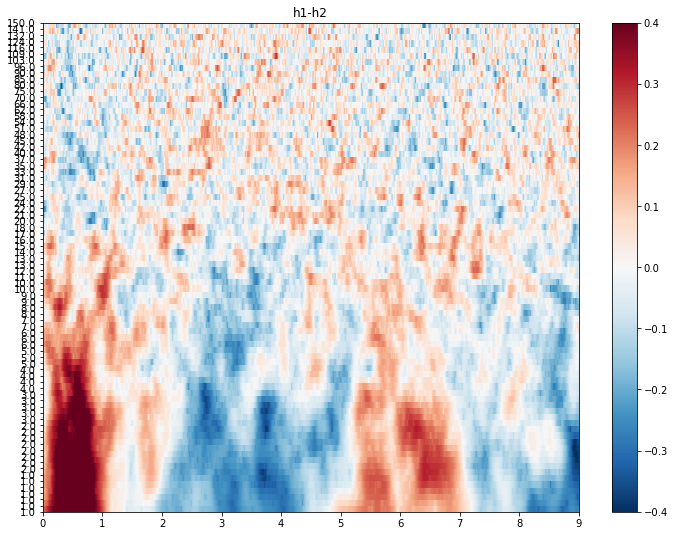

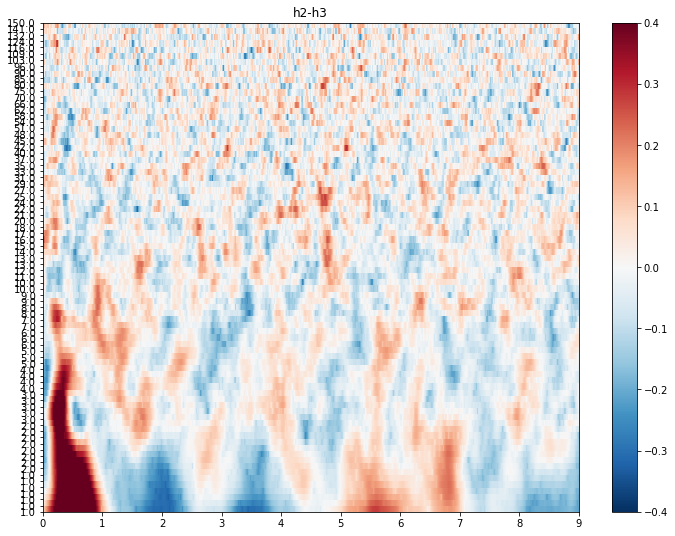

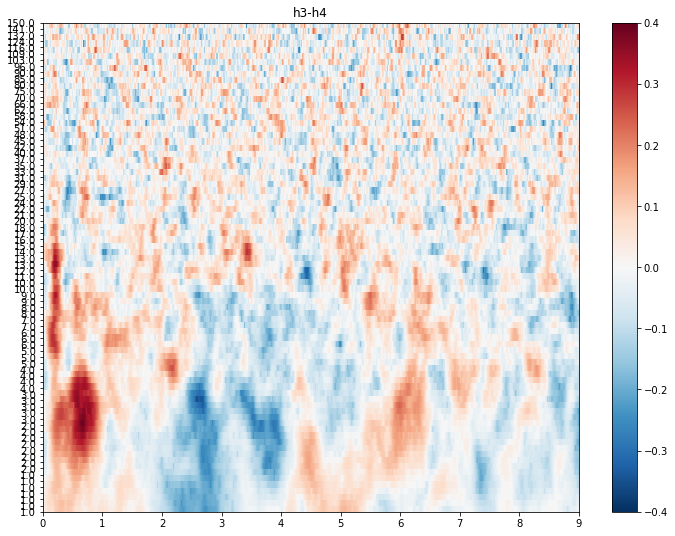

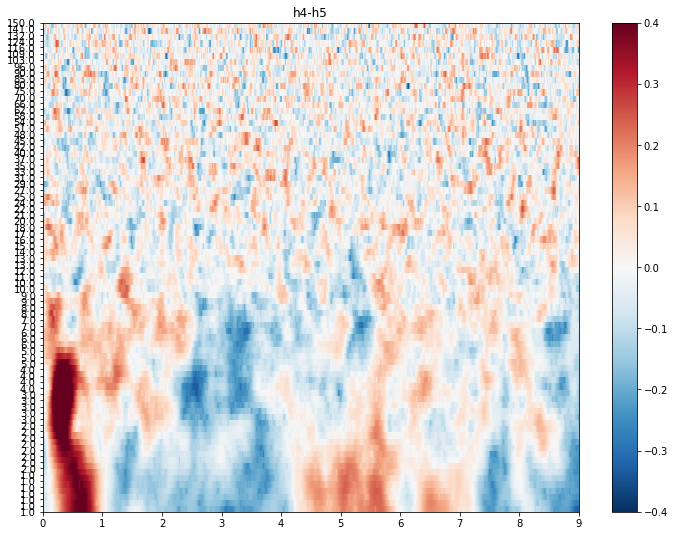

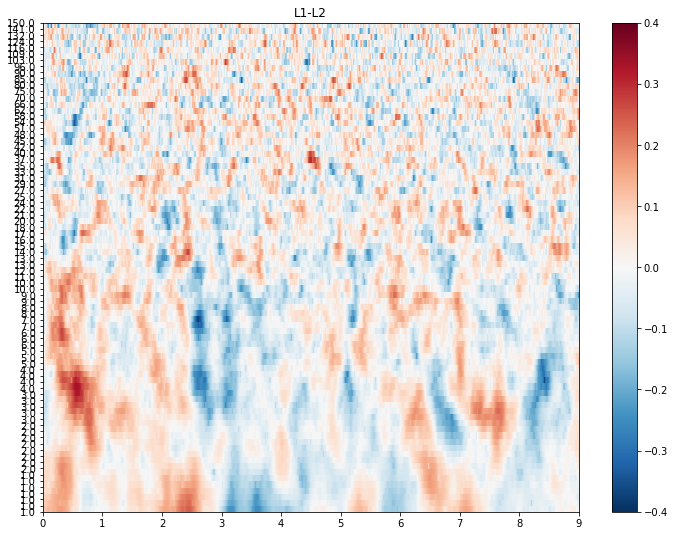

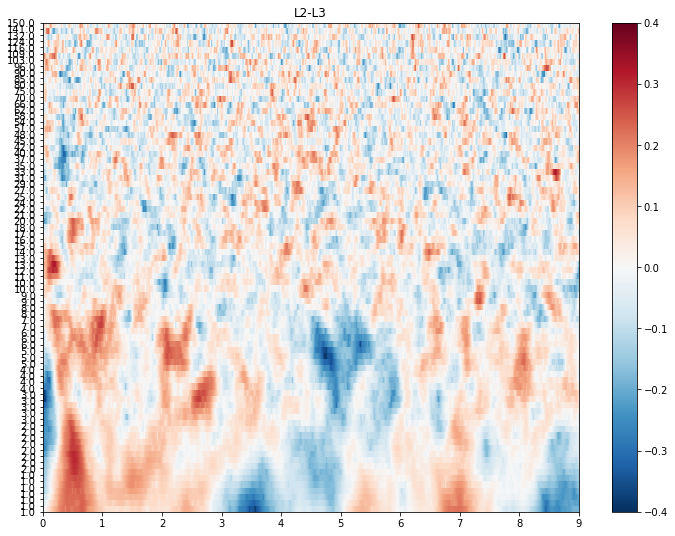

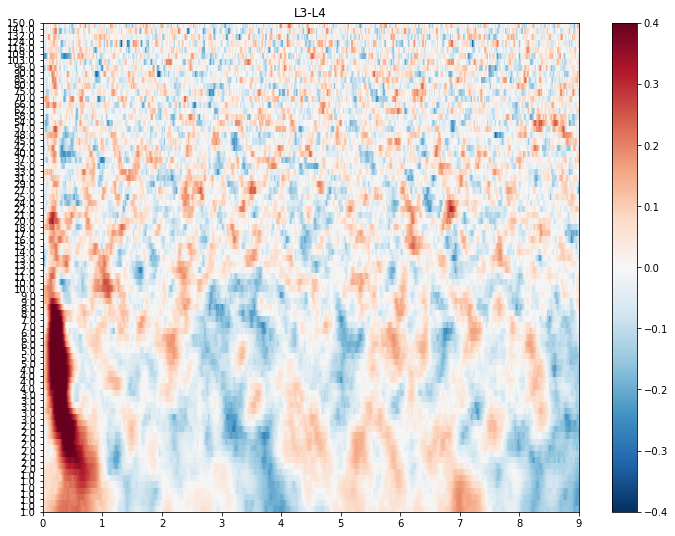

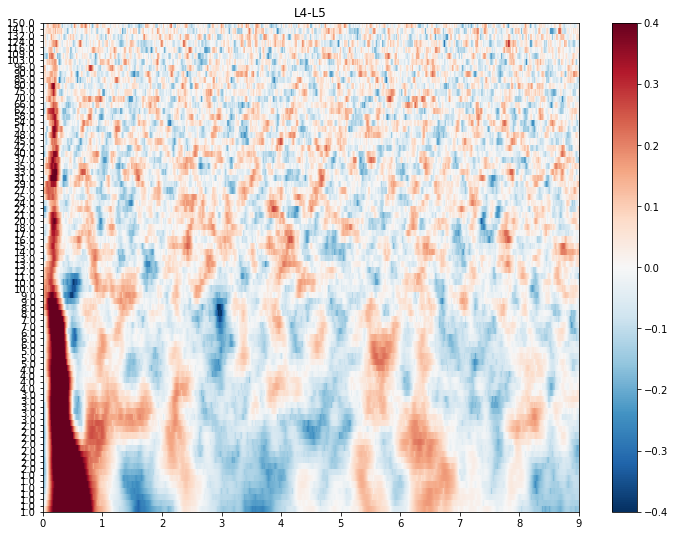

In [38]:
plt.rcParams['figure.figsize'] = [12, 9]

chix = 0
for ch in hc_pres_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(hc_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[0, 9, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(hc_pres_TFR.freqs),np.max(hc_pres_TFR.freqs),len(hc_pres_TFR.freqs)))
    ax.set_yticklabels(np.round(hc_pres_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}")
    fig.show()

    
    chix = chix + 1

In [39]:
# loop over channels and save csvs
fidx = np.where((freqs > 3) & (freqs < 8))[0]

for chix in range(len(hc_pres_TFR.ch_names)):

    trial_theta_power = hc_pres_TFR.data[:, chix, fidx, :].mean(axis = 1)
    channel_df = pd.DataFrame(trial_theta_power[:, ::50])
    channel_df['trial'] = good_epochs
        
    channel_df.to_csv(f"{preproc_data_dir}/theta_csvs/{hc_pres_TFR.ch_names[chix]}_entorhinal_trial_theta.csv")

## Amygdala

In [40]:
hc_pres_epochs = pres_locked_epochs.copy().pick_channels(amyg_list)


In [41]:
hc_pres_epochs= hc_pres_epochs.resample(1000)


In [42]:
## Compute TFR

hc_pres_TFR = []
hc_pres_TFR = MM_compute_TFR(hc_pres_epochs,freqs,n_cycles,baseline = (-1,9), zscore=True)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:  1.6min finished


Not setting metadata
log transforming
z-scoring to baseline


In [43]:
hc_pres_TFR.crop(tmin = 0, tmax = 9)


<EpochsTFR | time : [0.000000, 9.000000], freq : [1.000000, 150.000000], epochs : 163, channels : 3, ~2.62 GB>

/tmp/ipykernel_133838/1230075163.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


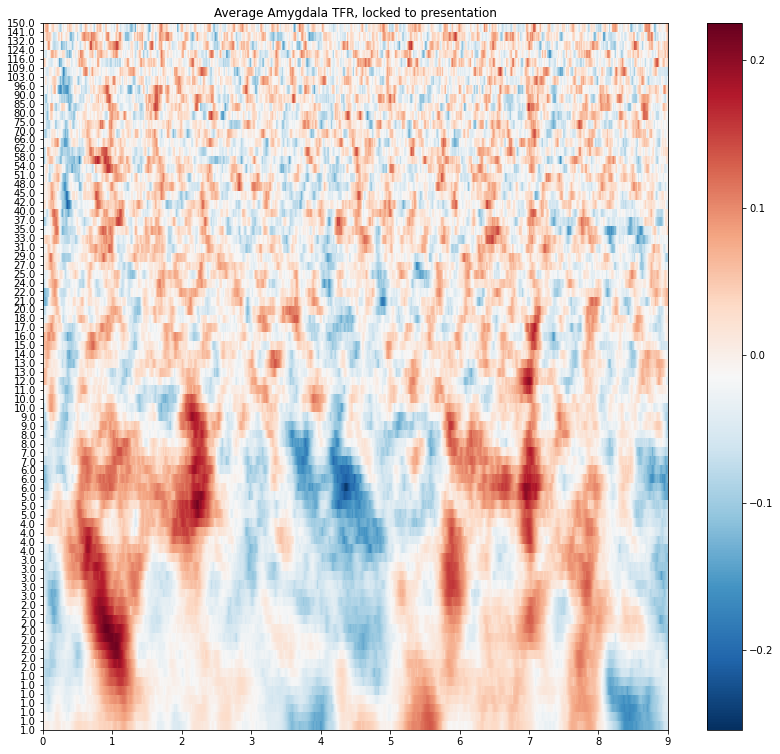

In [44]:
plt.rcParams['figure.figsize'] = [14, 13]


fig, ax = plt.subplots()
i = ax.imshow(hc_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[0, 9, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(hc_pres_TFR.freqs),np.max(hc_pres_TFR.freqs),len(hc_pres_TFR.freqs)))
ax.set_yticklabels(np.round(hc_pres_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Amygdala TFR, locked to presentation")
fig.show()


/tmp/ipykernel_133838/3358442580.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


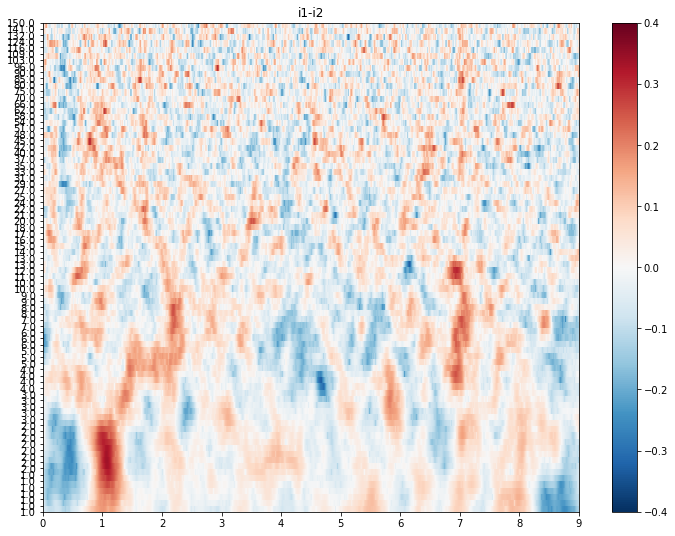

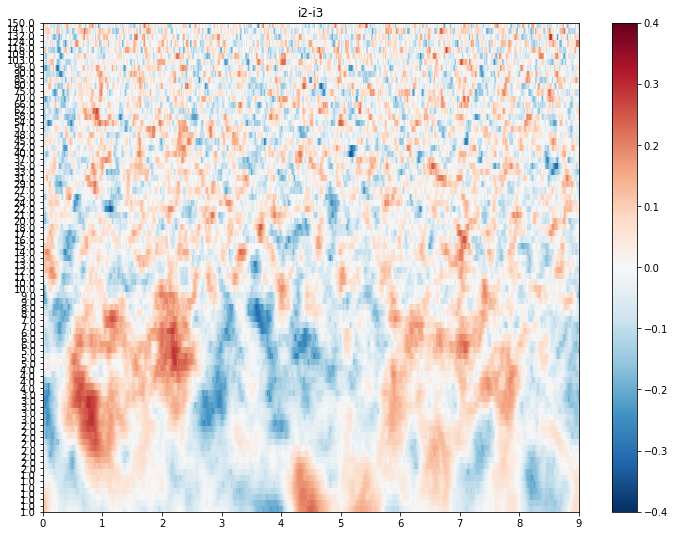

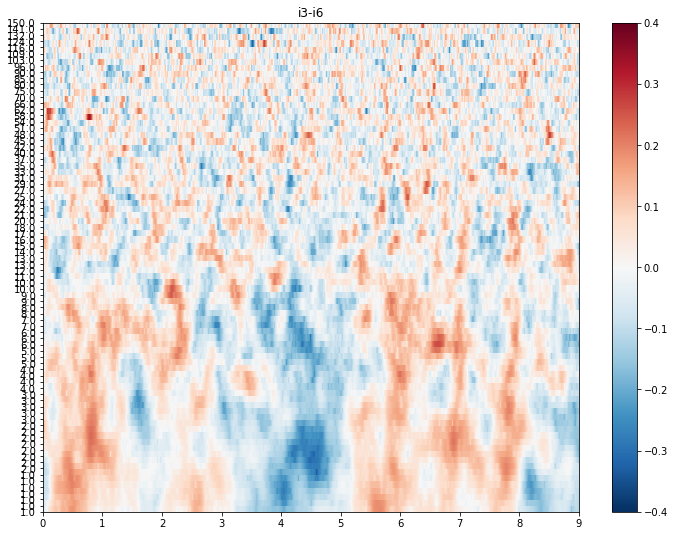

In [45]:
plt.rcParams['figure.figsize'] = [12, 9]

chix = 0
for ch in hc_pres_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(hc_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[0, 9, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(hc_pres_TFR.freqs),np.max(hc_pres_TFR.freqs),len(hc_pres_TFR.freqs)))
    ax.set_yticklabels(np.round(hc_pres_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}")
    fig.show()

    
    chix = chix + 1

In [46]:
# loop over channels and save csvs
fidx = np.where((freqs > 3) & (freqs < 8))[0]

for chix in range(len(hc_pres_TFR.ch_names)):

    trial_theta_power = hc_pres_TFR.data[:, chix, fidx, :].mean(axis = 1)
    channel_df = pd.DataFrame(trial_theta_power[:, ::50])
    channel_df['trial'] = good_epochs
        
    channel_df.to_csv(f"{preproc_data_dir}/theta_csvs/{hc_pres_TFR.ch_names[chix]}_amygdala_trial_theta.csv")

## MTG

In [54]:
hc_pres_epochs = pres_locked_epochs.copy().pick_channels(mtg_list)


In [55]:
mtg_list

['i11-i12',
 'i12-i13',
 'i13-i14',
 'J9-J10',
 'J10-J11',
 'J11-J12',
 'J12-J13',
 'J13-J14',
 'K13-K14',
 'K14-K15',
 'K15-K16']

In [56]:
hc_pres_epochs= hc_pres_epochs.resample(1000)


In [57]:
## Compute TFR

hc_pres_TFR = []
hc_pres_TFR = MM_compute_TFR(hc_pres_epochs,freqs,n_cycles,baseline = (-1,9), zscore=True)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  11 | elapsed:  1.9min remaining:  1.1min
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:  3.1min finished


Not setting metadata
log transforming
z-scoring to baseline


In [58]:
hc_pres_TFR.crop(tmin = 0, tmax = 9)


<EpochsTFR | time : [0.000000, 9.000000], freq : [1.000000, 150.000000], epochs : 163, channels : 11, ~9.62 GB>

/tmp/ipykernel_133838/1960066042.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


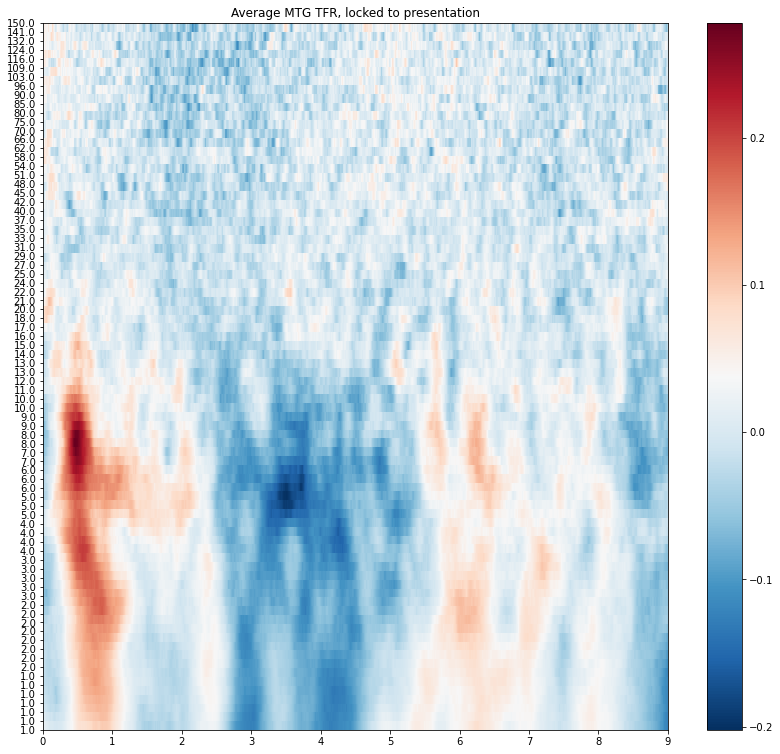

In [59]:
plt.rcParams['figure.figsize'] = [14, 13]


fig, ax = plt.subplots()
i = ax.imshow(hc_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[0, 9, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(hc_pres_TFR.freqs),np.max(hc_pres_TFR.freqs),len(hc_pres_TFR.freqs)))
ax.set_yticklabels(np.round(hc_pres_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average MTG TFR, locked to presentation")
fig.show()


/tmp/ipykernel_133838/3358442580.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


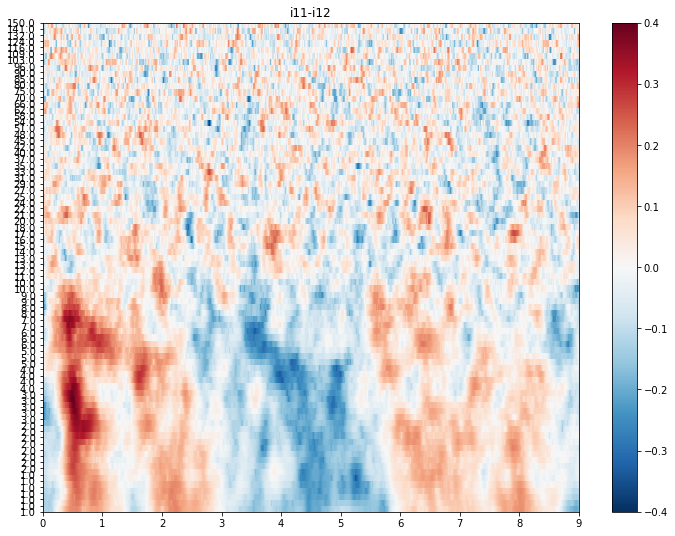

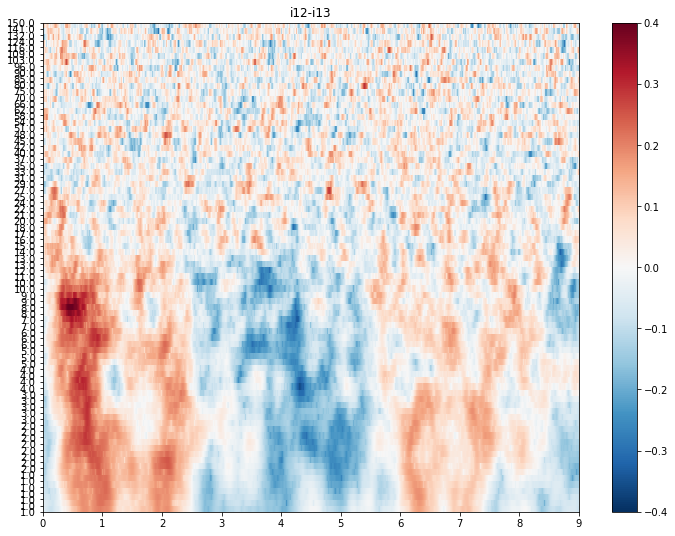

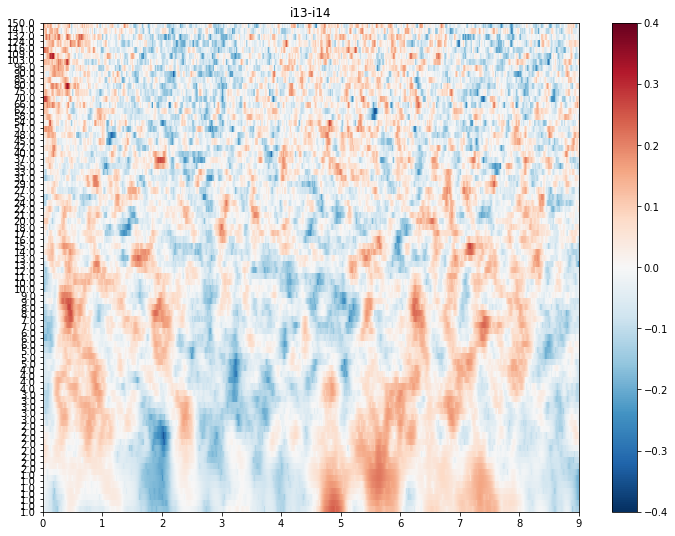

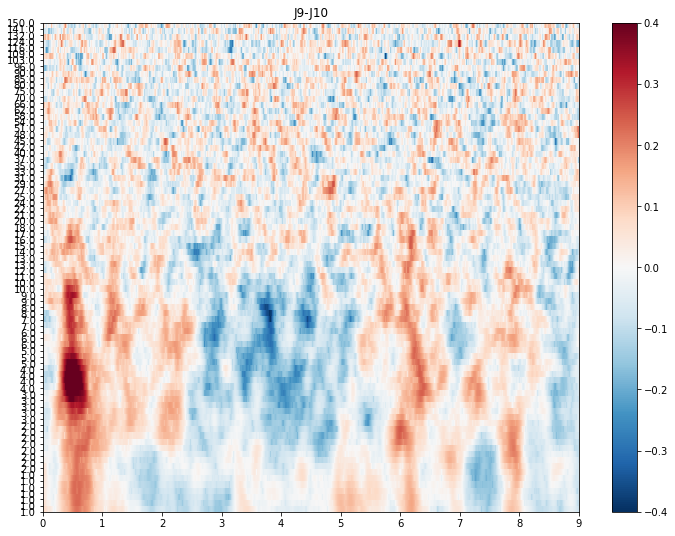

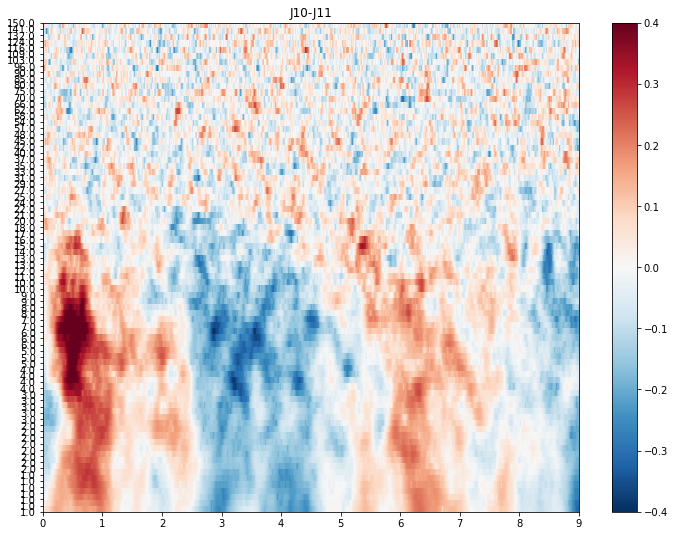

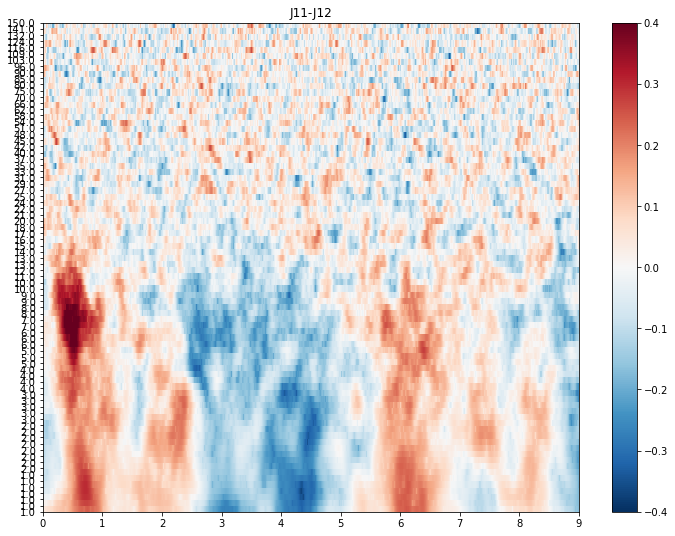

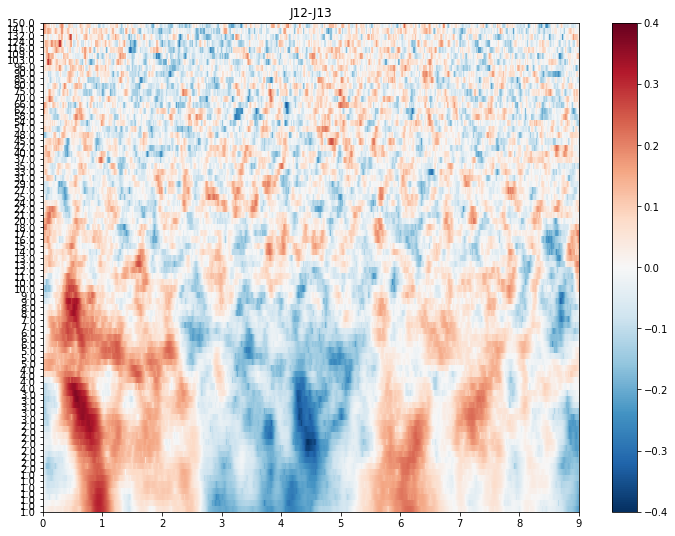

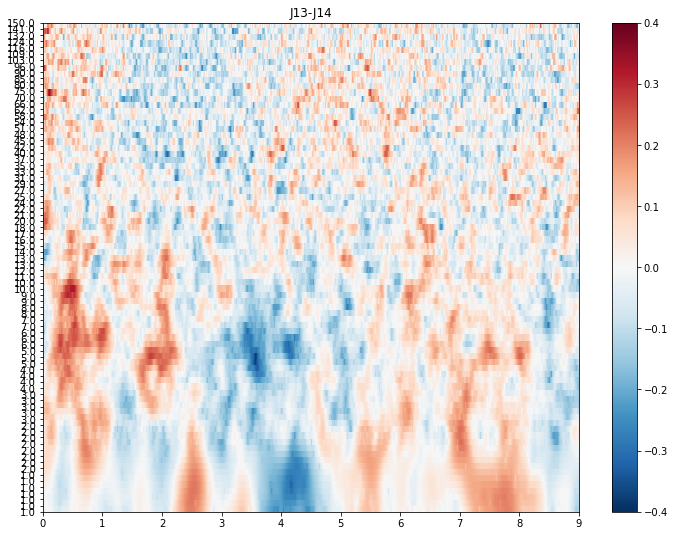

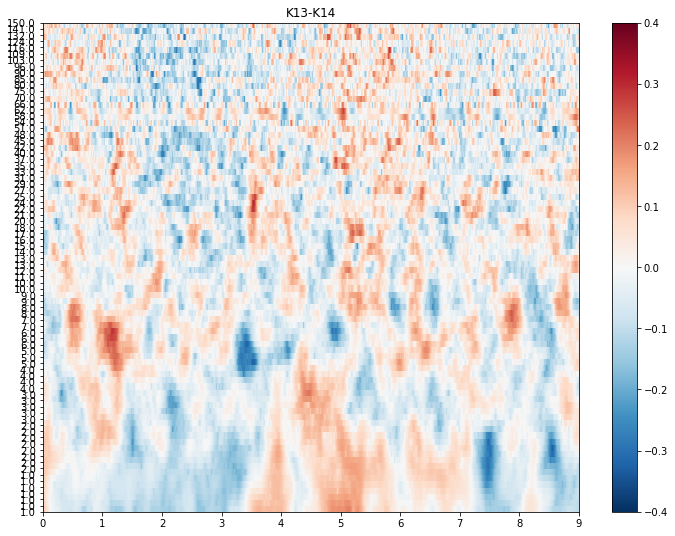

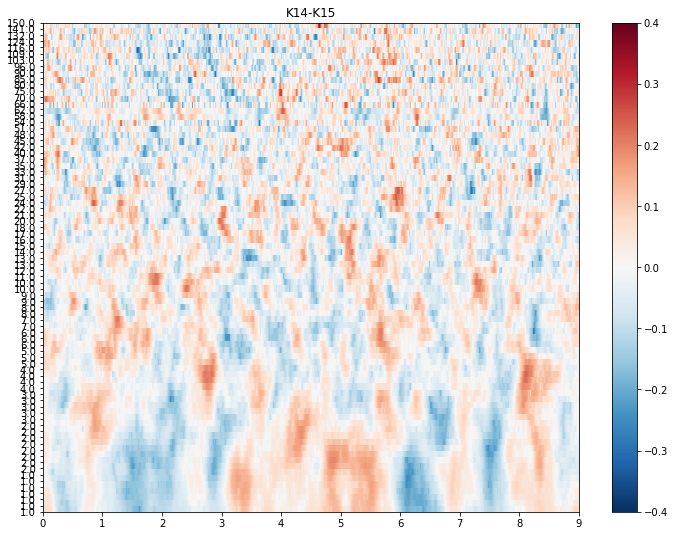

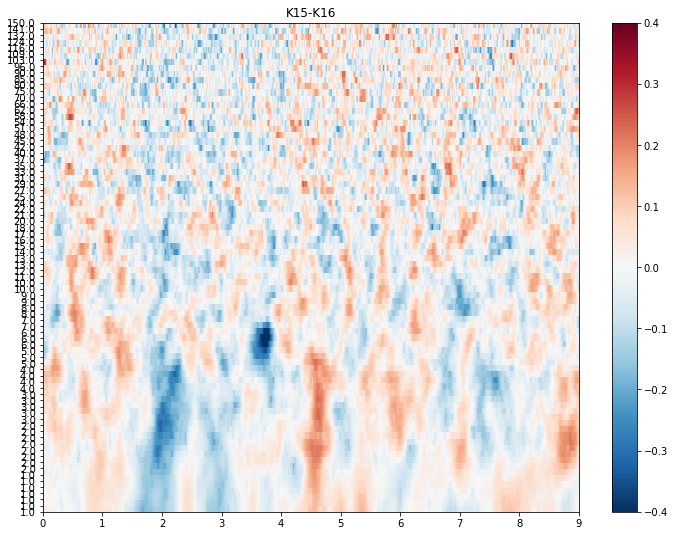

In [60]:
plt.rcParams['figure.figsize'] = [12, 9]

chix = 0
for ch in hc_pres_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(hc_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[0, 9, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(hc_pres_TFR.freqs),np.max(hc_pres_TFR.freqs),len(hc_pres_TFR.freqs)))
    ax.set_yticklabels(np.round(hc_pres_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}")
    fig.show()

    
    chix = chix + 1

In [61]:
# loop over channels and save csvs
fidx = np.where((freqs > 3) & (freqs < 8))[0]

for chix in range(len(hc_pres_TFR.ch_names)):

    trial_theta_power = hc_pres_TFR.data[:, chix, fidx, :].mean(axis = 1)
    channel_df = pd.DataFrame(trial_theta_power[:, ::50])
    channel_df['trial'] = good_epochs
        
    channel_df.to_csv(f"{preproc_data_dir}/theta_csvs/{hc_pres_TFR.ch_names[chix]}_mtg_trial_theta.csv")